In [2]:
import numpy as np
import cv2
#Import necessary functions
from matplotlib import pyplot as plt
import skimage.io
import skimage.color
from planarH import computeH_ransac, computeH_ransac_adaptive, compositeH, computeH_norm, compositeH_panorama, compositeH_panorama_blend
from itertools import permutations

#Write script for Q14
img_dict = {}
img_dict['img1'] = cv2.imread('../data/image1.png')
img_dict['img2'] = cv2.imread('../data/image2.png')
img_dict['img3'] = cv2.imread('../data/image3.png')
img_dict['img4'] = cv2.imread('../data/image4.png')

In [65]:
def get_avg_matched_points_distance(img1, img2):
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    orb = cv2.ORB_create(nfeatures=40000,
        scaleFactor=1.2,
        nlevels=8,
        edgeThreshold=31,
        firstLevel=0,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        patchSize=31,
        fastThreshold=20,)

    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches_cv = bf.match(des1, des2)

    # Sort matches by distance
    matches_cv = sorted(matches_cv, key=lambda x: x.distance)

    # Select the top 10% accurate matches

    num_matches = int(len(matches_cv) * 0.01)  # choose 10% of total matches
    best_matches = matches_cv[:num_matches]


    pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
    pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

    avg=[]
    for i in range(len(best_matches)):
        x1, y1 = pts1_best[i]
        x2, y2 = pts2_best[i][0]+img1.shape[1], pts2_best[i][1]
        distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
        avg = np.append((distance),avg)
    distance_avg= np.mean(avg)

    return distance_avg

In [82]:
def find_location_relationship(src_img, dst_img):

    src = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    dst = cv2.cvtColor(dst_img, cv2.COLOR_BGR2GRAY)

    src_diagonal = int((src.shape[1]**2 + src.shape[0]**2)**(1/2))

    dst_padded = cv2.copyMakeBorder(dst, top = src_diagonal, bottom= src_diagonal, left = src_diagonal, right = src_diagonal, borderType = 0)

    orb = cv2.ORB_create(nfeatures=40000,
        scaleFactor=1.2,
        nlevels=8,
        edgeThreshold=31,
        firstLevel=0,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        patchSize=31,
        fastThreshold=20,)

    kp1, des1 = orb.detectAndCompute(src, None)
    kp2, des2 = orb.detectAndCompute(dst_padded, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches_cv = bf.match(des1, des2)

    # Sort matches by distance
    matches_cv = sorted(matches_cv, key=lambda x: x.distance)

    # Select the top 10% accurate matches

    num_matches = int(len(matches_cv) * 0.01)  # choose 10% of total matches
    best_matches = matches_cv[:num_matches]


    pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
    pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

    H2to1, inliers = computeH_ransac_adaptive(pts2_best, pts1_best, 300, 2)

    H2to1 = computeH_norm(pts2_best[inliers], pts1_best[inliers])

    src_1 = np.array([[0], [0], [1]])
    src_1_hom = H2to1 @ src_1
    src_1_hom = src_1_hom[:2, :] / (src_1_hom[2, :] + np.finfo(float).eps)

    src_2 = np.array([[0],[src.shape[0]], [1]])
    src_2_hom = H2to1 @ src_2
    src_2_hom = src_2_hom[:2, :] / (src_2_hom[2, :] + np.finfo(float).eps)

    src_3 = np.array([[src.shape[1]], [src.shape[0]], [1]])
    src_3_hom = H2to1 @ src_3
    src_3_hom = src_3_hom[:2, :] / (src_3_hom[2, :] + np.finfo(float).eps)

    src_4 = np.array([[src.shape[1]], [0], [1]])
    src_4_hom = H2to1 @ src_4
    src_4_hom = src_4_hom[:2, :] / (src_4_hom[2, :] + np.finfo(float).eps)

    src_center = ((src_1_hom[0][0] + src_2_hom[0][0] + src_3_hom[0][0] + src_4_hom[0][0])/4, (src_1_hom[1][0] + src_2_hom[1][0] + src_3_hom[1][0] + src_4_hom[1][0])/4)
    dst_center = (dst.shape[1]/2 + src_diagonal, dst.shape[0]/2 + src_diagonal)

    x_dist = dst_center[0]- src_center[0]
    y_dist = dst_center[1]- src_center[1]
    if (abs(x_dist) > abs(y_dist)) and (x_dist > 0):
        src_loc = "left"
    elif (abs(x_dist) > abs(y_dist)) and (x_dist < 0):
        src_loc = "right"
    elif (abs(x_dist) < abs(y_dist)) and (y_dist > 0):
        src_loc = "top"
    elif (abs(x_dist) < abs(y_dist)) and (x_dist < 0):
        src_loc = "bottom"
    else:
        src_loc = "whatever"

    return src_loc

In [195]:
def find_destination_img(img_dict):
    
    img_loc_dict = {}

    loc_nto1 = {}
    loc_nto1["img2"] = find_location_relationship(img_dict["img2"], img_dict["img1"])
    loc_nto1["img3"] = find_location_relationship(img_dict["img3"], img_dict["img1"])
    loc_nto1["img4"] = find_location_relationship(img_dict["img4"], img_dict["img1"])
    img_loc_dict["img1"] = loc_nto1
    print("loc_nto1", loc_nto1)

    loc_nto2 = {}
    loc_nto2["img1"] = find_location_relationship(img_dict["img1"], img_dict["img2"])
    loc_nto2["img3"] = find_location_relationship(img_dict["img3"], img_dict["img2"])
    loc_nto2["img4"] = find_location_relationship(img_dict["img4"], img_dict["img2"])
    img_loc_dict["img2"] = loc_nto2
    print("loc_nto2", loc_nto2)

    loc_nto3 = {}
    loc_nto3["img1"] = find_location_relationship(img_dict["img1"], img_dict["img3"])
    loc_nto3["img2"] = find_location_relationship(img_dict["img2"], img_dict["img3"])
    loc_nto3["img4"] = find_location_relationship(img_dict["img4"], img_dict["img3"])
    img_loc_dict["img3"] = loc_nto3
    print("loc_nto3", loc_nto3)

    loc_nto4 = {}
    loc_nto4["img1"] = find_location_relationship(img_dict["img1"], img_dict["img4"])
    loc_nto4["img2"] = find_location_relationship(img_dict["img2"], img_dict["img4"])
    loc_nto4["img3"] = find_location_relationship(img_dict["img3"], img_dict["img4"])
    img_loc_dict["img4"] = loc_nto4
    print("loc_nto4", loc_nto4)

    return img_loc_dict

In [196]:
imgs_dict = find_destination_img(img_dict)

loc_nto1 {'img2': 'bottom', 'img3': 'left', 'img4': 'bottom'}
loc_nto2 {'img1': 'top', 'img3': 'left', 'img4': 'bottom'}
loc_nto3 {'img1': 'right', 'img2': 'right', 'img4': 'right'}
loc_nto4 {'img1': 'top', 'img2': 'top', 'img3': 'left'}


In [197]:
def find_key_with_largest_value(d):
    max_value = max(d.values())
    for key, value in d.items():
        if value == max_value:
            return key

In [198]:
dict_for_counting = {}

for i in imgs_dict.keys():
    dict_for_counting[i] = len(set(imgs_dict[i].values()))

center_img = find_key_with_largest_value(dict_for_counting)
print("Center img is", center_img)
for i, j in imgs_dict[center_img].items():
    print(i, "is on", j)

Center img is img2
img1 is on top
img3 is on left
img4 is on bottom


In [218]:
def image_stitching(img_src, img_dst):

    template_diagonal = int((img_src.shape[1]**2 + img_src.shape[0]**2)**(1/2))
    img_dst_padded = cv2.copyMakeBorder(img_dst, top = template_diagonal*2, bottom= template_diagonal*2, left = template_diagonal*2, right = template_diagonal*2, borderType = 0)

    orb = cv2.ORB_create(nfeatures=40000,
        scaleFactor=1.2,
        nlevels=8,
        edgeThreshold=31,
        firstLevel=0,
        WTA_K=2,
        scoreType=cv2.ORB_HARRIS_SCORE,
        patchSize=31,
        fastThreshold=20,)

    kp1, des1 = orb.detectAndCompute(img_src, None)
    kp2, des2 = orb.detectAndCompute(img_dst_padded, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches_cv = bf.match(des1, des2)

    # Sort matches by distance
    matches_cv = sorted(matches_cv, key=lambda x: x.distance)

    # Select the top 10% accurate matches

    num_matches = int(len(matches_cv) * 0.5)  # choose 10% of total matches
    best_matches = matches_cv[:num_matches]

    pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
    pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)

    H2to1, inliers = computeH_ransac_adaptive(pts2_best, pts1_best, 300, 2)

    H2to1 = computeH_norm(pts2_best[inliers], pts1_best[inliers])

    panorama = compositeH_panorama(H2to1, img_dst, img_src)

    result = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    plt.imshow(result)
    plt.axis('off')
    plt.show()
    
    return panorama

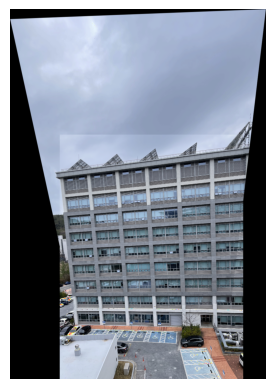

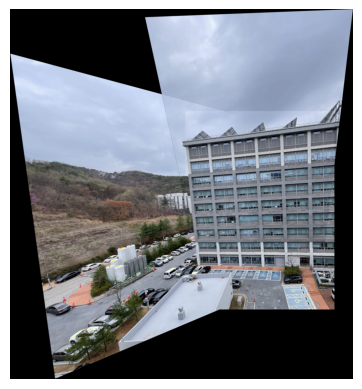

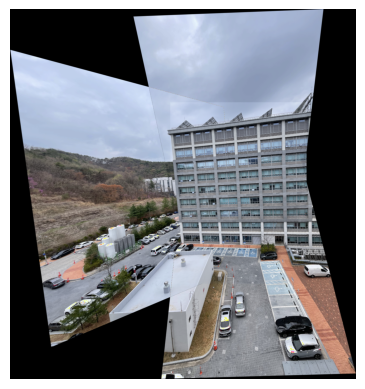

In [219]:
count = 2
for i in imgs_dict[center_img].keys():
    if count == 2:
        panorama = img_dict.get(center_img)
    panorama = image_stitching(img_dict.get(i), panorama)
    cv2.imwrite(f'../result/panorama_{count}.png', panorama)
    count += 1
